In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(690626, 828)
(690626, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/70 [..............................] - ETA: 1:45 - loss: 0.1247 - STD: 2.1584e-04 - MAE: 0.3388

 4/70 [>.............................] - ETA: 1s - loss: 0.0431 - STD: 4.0648e-04 - MAE: 0.1592  

 5/70 [=>............................] - ETA: 2s - loss: 0.0390 - STD: 3.6675e-04 - MAE: 0.1506

 6/70 [=>............................] - ETA: 2s - loss: 0.0368 - STD: 3.2980e-04 - MAE: 0.1467

 7/70 [==>...........................] - ETA: 2s - loss: 0.0355 - STD: 2.9799e-04 - MAE: 0.1449

 8/70 [==>...........................] - ETA: 2s - loss: 0.0346 - STD: 2.7111e-04 - MAE: 0.1439

 9/70 [==>...........................] - ETA: 2s - loss: 0.0339 - STD: 2.4839e-04 - MAE: 0.1433

10/70 [===>..........................] - ETA: 2s - loss: 0.0334 - STD: 2.2918e-04 - MAE: 0.1427

11/70 [===>..........................] - ETA: 2s - loss: 0.0328 - STD: 2.1276e-04 - MAE: 0.1418

12/70 [====>.........................] - ETA: 2s - loss: 0.0324 - STD: 1.9860e-04 - MAE: 0.1411

13/70 [====>.........................] - ETA: 2s - loss: 0.0318 - STD: 1.8636e-04 - MAE: 0.1400

14/70 [=====>........................] - ETA: 2s - loss: 0.0313 - STD: 1.7568e-04 - MAE: 0.1387

15/70 [=====>........................] - ETA: 2s - loss: 0.0307 - STD: 1.6639e-04 - MAE: 0.1371

16/70 [=====>........................] - ETA: 2s - loss: 0.0300 - STD: 1.5831e-04 - MAE: 0.1353

17/70 [======>.......................] - ETA: 2s - loss: 0.0293 - STD: 1.5132e-04 - MAE: 0.1332

18/70 [======>.......................] - ETA: 2s - loss: 0.0286 - STD: 1.4533e-04 - MAE: 0.1308

19/70 [=======>......................] - ETA: 2s - loss: 0.0278 - STD: 1.4025e-04 - MAE: 0.1283

20/70 [=======>......................] - ETA: 2s - loss: 0.0270 - STD: 1.3596e-04 - MAE: 0.1258

21/70 [========>.....................] - ETA: 2s - loss: 0.0262 - STD: 1.3232e-04 - MAE: 0.1234

22/70 [========>.....................] - ETA: 2s - loss: 0.0254 - STD: 1.2924e-04 - MAE: 0.1213

23/70 [========>.....................] - ETA: 2s - loss: 0.0248 - STD: 1.2658e-04 - MAE: 0.1196

24/70 [=========>....................] - ETA: 2s - loss: 0.0242 - STD: 1.2422e-04 - MAE: 0.1182

25/70 [=========>....................] - ETA: 2s - loss: 0.0237 - STD: 1.2208e-04 - MAE: 0.1172

26/70 [==========>...................] - ETA: 2s - loss: 0.0233 - STD: 1.2009e-04 - MAE: 0.1164

27/70 [==========>...................] - ETA: 2s - loss: 0.0229 - STD: 1.1816e-04 - MAE: 0.1157

28/70 [===========>..................] - ETA: 2s - loss: 0.0225 - STD: 1.1630e-04 - MAE: 0.1150

29/70 [===========>..................] - ETA: 2s - loss: 0.0222 - STD: 1.1453e-04 - MAE: 0.1142

30/70 [===========>..................] - ETA: 2s - loss: 0.0218 - STD: 1.1283e-04 - MAE: 0.1134

31/70 [============>.................] - ETA: 2s - loss: 0.0214 - STD: 1.1123e-04 - MAE: 0.1125

32/70 [============>.................] - ETA: 2s - loss: 0.0211 - STD: 1.0975e-04 - MAE: 0.1115

33/70 [=============>................] - ETA: 2s - loss: 0.0207 - STD: 1.0834e-04 - MAE: 0.1105

34/70 [=============>................] - ETA: 1s - loss: 0.0204 - STD: 1.0704e-04 - MAE: 0.1095

35/70 [==============>...............] - ETA: 1s - loss: 0.0201 - STD: 1.0580e-04 - MAE: 0.1085

36/70 [==============>...............] - ETA: 1s - loss: 0.0199 - STD: 1.0466e-04 - MAE: 0.1076

37/70 [==============>...............] - ETA: 1s - loss: 0.0196 - STD: 1.0364e-04 - MAE: 0.1068

38/70 [===============>..............] - ETA: 1s - loss: 0.0194 - STD: 1.0265e-04 - MAE: 0.1059

39/70 [===============>..............] - ETA: 1s - loss: 0.0191 - STD: 1.0180e-04 - MAE: 0.1052

40/70 [================>.............] - ETA: 1s - loss: 0.0189 - STD: 1.0099e-04 - MAE: 0.1045

41/70 [================>.............] - ETA: 1s - loss: 0.0189 - STD: 1.0014e-04 - MAE: 0.1037

44/70 [=================>............] - ETA: 1s - loss: 0.0183 - STD: 9.8573e-05 - MAE: 0.1018

46/70 [==================>...........] - ETA: 1s - loss: 0.0180 - STD: 9.8009e-05 - MAE: 0.1007

47/70 [===================>..........] - ETA: 1s - loss: 0.0178 - STD: 9.7843e-05 - MAE: 0.1003

48/70 [===================>..........] - ETA: 1s - loss: 0.0176 - STD: 9.7746e-05 - MAE: 0.0998

49/70 [====================>.........] - ETA: 1s - loss: 0.0175 - STD: 9.7716e-05 - MAE: 0.0994

50/70 [====================>.........] - ETA: 1s - loss: 0.0173 - STD: 9.7733e-05 - MAE: 0.0991

51/70 [====================>.........] - ETA: 1s - loss: 0.0172 - STD: 9.7814e-05 - MAE: 0.0987

52/70 [=====================>........] - ETA: 1s - loss: 0.0170 - STD: 9.7941e-05 - MAE: 0.0984

53/70 [=====================>........] - ETA: 1s - loss: 0.0169 - STD: 9.8121e-05 - MAE: 0.0981

54/70 [======================>.......] - ETA: 1s - loss: 0.0168 - STD: 9.8334e-05 - MAE: 0.0978

55/70 [======================>.......] - ETA: 0s - loss: 0.0167 - STD: 9.8573e-05 - MAE: 0.0975

56/70 [=======================>......] - ETA: 0s - loss: 0.0165 - STD: 9.8842e-05 - MAE: 0.0972

57/70 [=======================>......] - ETA: 0s - loss: 0.0164 - STD: 9.9157e-05 - MAE: 0.0969

58/70 [=======================>......] - ETA: 0s - loss: 0.0163 - STD: 9.9453e-05 - MAE: 0.0966

59/70 [========================>.....] - ETA: 0s - loss: 0.0162 - STD: 9.9801e-05 - MAE: 0.0962

60/70 [========================>.....] - ETA: 0s - loss: 0.0161 - STD: 1.0016e-04 - MAE: 0.0959

61/70 [=========================>....] - ETA: 0s - loss: 0.0160 - STD: 1.0057e-04 - MAE: 0.0956

62/70 [=========================>....] - ETA: 0s - loss: 0.0159 - STD: 1.0099e-04 - MAE: 0.0953

63/70 [==========================>...] - ETA: 0s - loss: 0.0158 - STD: 1.0146e-04 - MAE: 0.0950

64/70 [==========================>...] - ETA: 0s - loss: 0.0157 - STD: 1.0195e-04 - MAE: 0.0948

65/70 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 1.0246e-04 - MAE: 0.0945

66/70 [===========================>..] - ETA: 0s - loss: 0.0155 - STD: 1.0301e-04 - MAE: 0.0942

67/70 [===========================>..] - ETA: 0s - loss: 0.0154 - STD: 1.0359e-04 - MAE: 0.0939

68/70 [============================>.] - ETA: 0s - loss: 0.0154 - STD: 1.0422e-04 - MAE: 0.0937

69/70 [============================>.] - ETA: 0s - loss: 0.0153 - STD: 1.0488e-04 - MAE: 0.0934

70/70 [==============================] - ETA: 0s - loss: 0.0152 - STD: 1.0559e-04 - MAE: 0.0932

70/70 [==============================] - 6s 71ms/step - loss: 0.0152 - STD: 1.0559e-04 - MAE: 0.0932 - val_loss: 0.0094 - val_STD: 1.1607e-04 - val_MAE: 0.0763


Epoch 2/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0099 - STD: 1.5788e-04 - MAE: 0.0781

 2/70 [..............................] - ETA: 3s - loss: 0.0100 - STD: 1.6033e-04 - MAE: 0.0786

 3/70 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.6310e-04 - MAE: 0.0786

 4/70 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.6547e-04 - MAE: 0.0784

 5/70 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.6785e-04 - MAE: 0.0785

 6/70 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.6983e-04 - MAE: 0.0784

 7/70 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.7205e-04 - MAE: 0.0785

 8/70 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.7405e-04 - MAE: 0.0784

 9/70 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.7629e-04 - MAE: 0.0784

10/70 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.7854e-04 - MAE: 0.0785

11/70 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.8066e-04 - MAE: 0.0785

12/70 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.8276e-04 - MAE: 0.0784

13/70 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.8486e-04 - MAE: 0.0784

14/70 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.8707e-04 - MAE: 0.0783

15/70 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.8928e-04 - MAE: 0.0782

16/70 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.9141e-04 - MAE: 0.0781

17/70 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.9374e-04 - MAE: 0.0780

18/70 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9617e-04 - MAE: 0.0780

19/70 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.9871e-04 - MAE: 0.0780

20/70 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.0123e-04 - MAE: 0.0780

21/70 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.0391e-04 - MAE: 0.0781

22/70 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.0661e-04 - MAE: 0.0780

23/70 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.0933e-04 - MAE: 0.0780

25/70 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.1501e-04 - MAE: 0.0781

26/70 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.1804e-04 - MAE: 0.0781

27/70 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.2114e-04 - MAE: 0.0782

28/70 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.2423e-04 - MAE: 0.0782

29/70 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.2736e-04 - MAE: 0.0782

30/70 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.3059e-04 - MAE: 0.0782

31/70 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.3384e-04 - MAE: 0.0782

32/70 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.3714e-04 - MAE: 0.0781

33/70 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.4045e-04 - MAE: 0.0781

34/70 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.4390e-04 - MAE: 0.0781

35/70 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.4732e-04 - MAE: 0.0781

36/70 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.5096e-04 - MAE: 0.0781

37/70 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.5454e-04 - MAE: 0.0780

38/70 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.5831e-04 - MAE: 0.0780

39/70 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.6219e-04 - MAE: 0.0780

40/70 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.6606e-04 - MAE: 0.0780

41/70 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.7015e-04 - MAE: 0.0780

42/70 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.7429e-04 - MAE: 0.0780

43/70 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.7864e-04 - MAE: 0.0780

44/70 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.8307e-04 - MAE: 0.0780

45/70 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.8762e-04 - MAE: 0.0780

46/70 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.9233e-04 - MAE: 0.0779

47/70 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.9713e-04 - MAE: 0.0779

48/70 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.0221e-04 - MAE: 0.0780

49/70 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.0731e-04 - MAE: 0.0780

50/70 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.1245e-04 - MAE: 0.0779

51/70 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.1778e-04 - MAE: 0.0779

52/70 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.2335e-04 - MAE: 0.0780

53/70 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.2905e-04 - MAE: 0.0780

54/70 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.3478e-04 - MAE: 0.0779

55/70 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.4081e-04 - MAE: 0.0779

56/70 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.4705e-04 - MAE: 0.0779

57/70 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.5333e-04 - MAE: 0.0779

58/70 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.5986e-04 - MAE: 0.0779

59/70 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.6658e-04 - MAE: 0.0779

60/70 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.7349e-04 - MAE: 0.0779

61/70 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.8068e-04 - MAE: 0.0779

62/70 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.8809e-04 - MAE: 0.0779

63/70 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.9563e-04 - MAE: 0.0779

64/70 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.0354e-04 - MAE: 0.0778

65/70 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.1165e-04 - MAE: 0.0778

66/70 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.1989e-04 - MAE: 0.0778

67/70 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.2853e-04 - MAE: 0.0778

68/70 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.3744e-04 - MAE: 0.0778

69/70 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.4683e-04 - MAE: 0.0778

70/70 [==============================] - ETA: 0s - loss: 0.0099 - STD: 4.5660e-04 - MAE: 0.0778

70/70 [==============================] - 4s 60ms/step - loss: 0.0099 - STD: 4.5660e-04 - MAE: 0.0778 - val_loss: 0.0093 - val_STD: 8.3514e-04 - val_MAE: 0.0760


Epoch 3/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0099 - STD: 0.0012 - MAE: 0.0781

 2/70 [..............................] - ETA: 4s - loss: 0.0099 - STD: 0.0012 - MAE: 0.0778

 3/70 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 0.0012 - MAE: 0.0773

 4/70 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0776

 5/70 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 0.0013 - MAE: 0.0777

 6/70 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 0.0013 - MAE: 0.0778

 7/70 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 0.0013 - MAE: 0.0777

 8/70 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0777

 9/70 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 0.0014 - MAE: 0.0778

10/70 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 0.0014 - MAE: 0.0778

11/70 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0777

12/70 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0777

13/70 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0776

14/70 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0776

15/70 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0775

16/70 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0775

17/70 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0775

18/70 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0774

19/70 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0774

20/70 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0774

21/70 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0774

22/70 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0774

23/70 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0019 - MAE: 0.0774

24/70 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0019 - MAE: 0.0774

25/70 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0020 - MAE: 0.0774

26/70 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0020 - MAE: 0.0774

27/70 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0773

28/70 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0773

29/70 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0773

30/70 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0773

31/70 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0773

33/70 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0773

34/70 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0773

35/70 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0773

36/70 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0772

37/70 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0772

38/70 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0772

39/70 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0772

40/70 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0031 - MAE: 0.0772

41/70 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0031 - MAE: 0.0771

42/70 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0771

43/70 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0771

44/70 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0771

45/70 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0770

46/70 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0770

47/70 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0770

48/70 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0039 - MAE: 0.0769

49/70 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0041 - MAE: 0.0769

50/70 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0042 - MAE: 0.0769

51/70 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0043 - MAE: 0.0768

52/70 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0045 - MAE: 0.0768

53/70 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.0046 - MAE: 0.0768

54/70 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.0048 - MAE: 0.0767

55/70 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0767

56/70 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0767

57/70 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0053 - MAE: 0.0766

58/70 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0766

59/70 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0057 - MAE: 0.0765

60/70 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0059 - MAE: 0.0765

61/70 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0061 - MAE: 0.0764

62/70 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0063 - MAE: 0.0764

63/70 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0065 - MAE: 0.0763

64/70 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0067 - MAE: 0.0763

65/70 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0069 - MAE: 0.0763

66/70 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0071 - MAE: 0.0762

67/70 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0074 - MAE: 0.0761

68/70 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0076 - MAE: 0.0761

69/70 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0078 - MAE: 0.0760

70/70 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.0081 - MAE: 0.0759

70/70 [==============================] - 4s 61ms/step - loss: 0.0093 - STD: 0.0081 - MAE: 0.0759 - val_loss: 0.0079 - val_STD: 0.0179 - val_MAE: 0.0703


Epoch 4/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0085 - STD: 0.0255 - MAE: 0.0721

 2/70 [..............................] - ETA: 4s - loss: 0.0085 - STD: 0.0257 - MAE: 0.0721

 3/70 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.0261 - MAE: 0.0720

 4/70 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.0264 - MAE: 0.0721

 5/70 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.0268 - MAE: 0.0717

 6/70 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.0271 - MAE: 0.0718

 7/70 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0274 - MAE: 0.0717

 8/70 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0277 - MAE: 0.0718

 9/70 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0281 - MAE: 0.0717

10/70 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.0284 - MAE: 0.0716

11/70 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.0287 - MAE: 0.0715

12/70 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0290 - MAE: 0.0714

13/70 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0293 - MAE: 0.0713

14/70 [=====>........................] - ETA: 3s - loss: 0.0082 - STD: 0.0296 - MAE: 0.0712

15/70 [=====>........................] - ETA: 3s - loss: 0.0082 - STD: 0.0298 - MAE: 0.0711

16/70 [=====>........................] - ETA: 3s - loss: 0.0082 - STD: 0.0301 - MAE: 0.0711

17/70 [======>.......................] - ETA: 3s - loss: 0.0082 - STD: 0.0303 - MAE: 0.0711

18/70 [======>.......................] - ETA: 3s - loss: 0.0082 - STD: 0.0306 - MAE: 0.0709

19/70 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0308 - MAE: 0.0709

20/70 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0310 - MAE: 0.0709

21/70 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0312 - MAE: 0.0708

22/70 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0314 - MAE: 0.0708

23/70 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0316 - MAE: 0.0708

24/70 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0318 - MAE: 0.0707

25/70 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0320 - MAE: 0.0706

26/70 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.0322 - MAE: 0.0706

27/70 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.0324 - MAE: 0.0705

28/70 [===========>..................] - ETA: 2s - loss: 0.0081 - STD: 0.0326 - MAE: 0.0705

29/70 [===========>..................] - ETA: 2s - loss: 0.0081 - STD: 0.0328 - MAE: 0.0704

30/70 [===========>..................] - ETA: 2s - loss: 0.0081 - STD: 0.0330 - MAE: 0.0704

31/70 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0331 - MAE: 0.0704

32/70 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0333 - MAE: 0.0703

33/70 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.0335 - MAE: 0.0703

34/70 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.0336 - MAE: 0.0702

35/70 [==============>...............] - ETA: 2s - loss: 0.0081 - STD: 0.0338 - MAE: 0.0702

36/70 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0339 - MAE: 0.0701

37/70 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0341 - MAE: 0.0701

38/70 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0342 - MAE: 0.0701

39/70 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0343 - MAE: 0.0700

40/70 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0345 - MAE: 0.0700

41/70 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0346 - MAE: 0.0700

42/70 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0347 - MAE: 0.0700

43/70 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0349 - MAE: 0.0699

44/70 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0350 - MAE: 0.0699

45/70 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0351 - MAE: 0.0698

46/70 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0353 - MAE: 0.0697

47/70 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0354 - MAE: 0.0697

48/70 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0355 - MAE: 0.0696

49/70 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0357 - MAE: 0.0696

50/70 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0358 - MAE: 0.0696

51/70 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0359 - MAE: 0.0695

52/70 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0360 - MAE: 0.0695

53/70 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0361 - MAE: 0.0694

54/70 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0362 - MAE: 0.0694

55/70 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0363 - MAE: 0.0693

56/70 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0364 - MAE: 0.0693

57/70 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0365 - MAE: 0.0692

58/70 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0365 - MAE: 0.0692

59/70 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0366 - MAE: 0.0692

60/70 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0367 - MAE: 0.0691

61/70 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0368 - MAE: 0.0691

62/70 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0369 - MAE: 0.0690

63/70 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0370 - MAE: 0.0690

65/70 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0372 - MAE: 0.0689

66/70 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0373 - MAE: 0.0688

67/70 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0374 - MAE: 0.0688

68/70 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0374 - MAE: 0.0687

69/70 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0375 - MAE: 0.0687

70/70 [==============================] - ETA: 0s - loss: 0.0078 - STD: 0.0376 - MAE: 0.0686

70/70 [==============================] - 4s 60ms/step - loss: 0.0078 - STD: 0.0376 - MAE: 0.0686 - val_loss: 0.0066 - val_STD: 0.0301 - val_MAE: 0.0626


Epoch 5/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0070 - STD: 0.0433 - MAE: 0.0648

 2/70 [..............................] - ETA: 3s - loss: 0.0071 - STD: 0.0431 - MAE: 0.0646

 3/70 [>.............................] - ETA: 3s - loss: 0.0071 - STD: 0.0432 - MAE: 0.0644

 4/70 [>.............................] - ETA: 3s - loss: 0.0071 - STD: 0.0434 - MAE: 0.0642

 5/70 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.0438 - MAE: 0.0639

 6/70 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.0439 - MAE: 0.0637

 7/70 [==>...........................] - ETA: 3s - loss: 0.0070 - STD: 0.0440 - MAE: 0.0638

 8/70 [==>...........................] - ETA: 3s - loss: 0.0070 - STD: 0.0443 - MAE: 0.0637

 9/70 [==>...........................] - ETA: 3s - loss: 0.0070 - STD: 0.0444 - MAE: 0.0636

10/70 [===>..........................] - ETA: 3s - loss: 0.0069 - STD: 0.0446 - MAE: 0.0635

11/70 [===>..........................] - ETA: 3s - loss: 0.0069 - STD: 0.0448 - MAE: 0.0635

12/70 [====>.........................] - ETA: 3s - loss: 0.0069 - STD: 0.0451 - MAE: 0.0634

13/70 [====>.........................] - ETA: 3s - loss: 0.0069 - STD: 0.0453 - MAE: 0.0632

14/70 [=====>........................] - ETA: 3s - loss: 0.0069 - STD: 0.0456 - MAE: 0.0632

15/70 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.0458 - MAE: 0.0630

16/70 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.0461 - MAE: 0.0630

17/70 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0464 - MAE: 0.0628

18/70 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0467 - MAE: 0.0627

19/70 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0471 - MAE: 0.0627

20/70 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0473 - MAE: 0.0626

21/70 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0476 - MAE: 0.0625

22/70 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0481 - MAE: 0.0624

23/70 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0483 - MAE: 0.0623

24/70 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0486 - MAE: 0.0622

25/70 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0490 - MAE: 0.0621

26/70 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0491 - MAE: 0.0620

27/70 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0494 - MAE: 0.0619

28/70 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0496 - MAE: 0.0618

29/70 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0498 - MAE: 0.0617

30/70 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0501 - MAE: 0.0617

31/70 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0502 - MAE: 0.0615

32/70 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0504 - MAE: 0.0614

33/70 [=============>................] - ETA: 2s - loss: 0.0065 - STD: 0.0507 - MAE: 0.0615

34/70 [=============>................] - ETA: 2s - loss: 0.0065 - STD: 0.0508 - MAE: 0.0614

35/70 [==============>...............] - ETA: 2s - loss: 0.0065 - STD: 0.0510 - MAE: 0.0613

36/70 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0613

37/70 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0612

38/70 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0515 - MAE: 0.0611

39/70 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0518 - MAE: 0.0611

40/70 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0520 - MAE: 0.0610

41/70 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0521 - MAE: 0.0609

42/70 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0522 - MAE: 0.0609

43/70 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0608

44/70 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0607

45/70 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0606

46/70 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0528 - MAE: 0.0606

47/70 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0606

48/70 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.0531 - MAE: 0.0605

49/70 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0532 - MAE: 0.0604

50/70 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0604

51/70 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0603

52/70 [=====================>........] - ETA: 1s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0602

53/70 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0602

54/70 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0601

55/70 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0600

56/70 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0600

57/70 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0600

58/70 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0599

59/70 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0544 - MAE: 0.0598

60/70 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0597

62/70 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0597

63/70 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0596

64/70 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0596

65/70 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0595

66/70 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0594

67/70 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0594

68/70 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0553 - MAE: 0.0593

69/70 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0592

70/70 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0592

70/70 [==============================] - 4s 60ms/step - loss: 0.0061 - STD: 0.0555 - MAE: 0.0592 - val_loss: 0.0050 - val_STD: 0.0543 - val_MAE: 0.0550


Epoch 6/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0562

 2/70 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0556

 3/70 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0555

 4/70 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0557

 5/70 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0554

 6/70 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0553

 7/70 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0628 - MAE: 0.0554

 8/70 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0628 - MAE: 0.0552

 9/70 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0551

10/70 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0552

11/70 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0551

12/70 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0550

13/70 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0549

14/70 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0548

15/70 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0547

16/70 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0547

17/70 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0547

18/70 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0547

19/70 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0547

20/70 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0547

21/70 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0635 - MAE: 0.0546

22/70 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0545

23/70 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0546

24/70 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0635 - MAE: 0.0545

25/70 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0545

26/70 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0545

27/70 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0544

28/70 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0544

29/70 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0544

30/70 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0544

31/70 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0544

32/70 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0543

33/70 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0543

34/70 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0542

35/70 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0542

36/70 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0542

37/70 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0642 - MAE: 0.0541

38/70 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0541

39/70 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0540

41/70 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0540

42/70 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0540

43/70 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0644 - MAE: 0.0540

44/70 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0540

45/70 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

46/70 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0539

47/70 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540

48/70 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0540

49/70 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0540

50/70 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0540

51/70 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0540

52/70 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0540

53/70 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540

54/70 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0539

55/70 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540

56/70 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

57/70 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0539

58/70 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0539

59/70 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

60/70 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0539

61/70 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0538

62/70 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0539

63/70 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

64/70 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

65/70 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0540

66/70 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

67/70 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0539

68/70 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0540

69/70 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0540

70/70 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540

70/70 [==============================] - 4s 60ms/step - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540 - val_loss: 0.0046 - val_STD: 0.0619 - val_MAE: 0.0537


Epoch 7/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0548

 2/70 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0549

 3/70 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538

 4/70 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0531

 5/70 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

 6/70 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0534

 7/70 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0530

 8/70 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0529

10/70 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0529

11/70 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0528

12/70 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0528

13/70 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0527

14/70 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0526

15/70 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0525

16/70 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0525

17/70 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0525

18/70 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0524

19/70 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0523

20/70 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0523

21/70 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0523

22/70 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0522

23/70 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0522

24/70 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0521

25/70 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0521

26/70 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0520

27/70 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0520

28/70 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0520

29/70 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0519

30/70 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0519

31/70 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0519

32/70 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0519

33/70 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0518

34/70 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0518

35/70 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0518

36/70 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0518

37/70 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0517

38/70 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0517

39/70 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0517

40/70 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0516

41/70 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0516

42/70 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0516

43/70 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0516

44/70 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0516

45/70 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0516

46/70 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0515

47/70 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0515

48/70 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0515

49/70 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0515

50/70 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0515

51/70 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0515

52/70 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0514

53/70 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0514

54/70 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0514

55/70 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0514

56/70 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0514

57/70 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0514

58/70 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0513

59/70 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0513

60/70 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0513

61/70 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0513

62/70 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0513

63/70 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0513

64/70 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0513

65/70 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0512

66/70 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0512

67/70 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0512

68/70 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0512

69/70 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0512

70/70 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0512

70/70 [==============================] - 4s 60ms/step - loss: 0.0047 - STD: 0.0692 - MAE: 0.0512 - val_loss: 0.0043 - val_STD: 0.0639 - val_MAE: 0.0495


Epoch 8/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

 2/70 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0495

 3/70 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0497

 4/70 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0499

 5/70 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0499

 6/70 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

 7/70 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0501

 8/70 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0500

 9/70 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0500

10/70 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0500

11/70 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0500

12/70 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0499

13/70 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0500

14/70 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0500

15/70 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0501

16/70 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0501

17/70 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0502

18/70 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0501

19/70 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

20/70 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

21/70 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505

22/70 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

23/70 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

24/70 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

25/70 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507

26/70 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0507

27/70 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0508

28/70 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0507

29/70 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508

30/70 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0508

31/70 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

32/70 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

33/70 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

34/70 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

35/70 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

36/70 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0507

37/70 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0507

38/70 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0507

39/70 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0507

40/70 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0507

42/70 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

43/70 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0507

44/70 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0508

45/70 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0508

46/70 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0507

47/70 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0507

48/70 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

49/70 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

50/70 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

51/70 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0507

52/70 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0507

53/70 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

54/70 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

55/70 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

56/70 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

57/70 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

58/70 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

59/70 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

60/70 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

61/70 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

62/70 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

63/70 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

64/70 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

65/70 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

66/70 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

67/70 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

68/70 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0504

69/70 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0504

70/70 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

70/70 [==============================] - 4s 59ms/step - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504 - val_loss: 0.0042 - val_STD: 0.0634 - val_MAE: 0.0487


Epoch 9/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0485

 2/70 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0490

 3/70 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0490

 4/70 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0491

 5/70 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492

 6/70 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0491

 7/70 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0491

 8/70 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0491

 9/70 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0491

10/70 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0492

11/70 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

12/70 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

13/70 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

14/70 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492

15/70 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

16/70 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

17/70 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

18/70 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

19/70 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

20/70 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

21/70 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

22/70 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

23/70 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

24/70 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

25/70 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

26/70 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

27/70 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

28/70 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494

29/70 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

30/70 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

31/70 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

32/70 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

33/70 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

34/70 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

35/70 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0495

36/70 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

37/70 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0495

38/70 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

39/70 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

40/70 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

41/70 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

42/70 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

43/70 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

44/70 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

45/70 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

46/70 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

47/70 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

48/70 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

49/70 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

50/70 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

51/70 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

52/70 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

53/70 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

54/70 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

55/70 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

56/70 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

57/70 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0495

58/70 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

59/70 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

60/70 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

61/70 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

62/70 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

63/70 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

64/70 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

65/70 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

66/70 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

67/70 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

68/70 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

69/70 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

70/70 [==============================] - 4s 60ms/step - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496 - val_loss: 0.0045 - val_STD: 0.0577 - val_MAE: 0.0492


Epoch 10/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0499

 2/70 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0506

 3/70 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0500

 4/70 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0695 - MAE: 0.0496

 5/70 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0501

 6/70 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0498

 7/70 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0497

 8/70 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

 9/70 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0498

10/70 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0498

11/70 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0497

12/70 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0497

13/70 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0498

14/70 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0497

15/70 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0496

16/70 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497

17/70 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0497

18/70 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0496

19/70 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0496

20/70 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0496

21/70 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0496

22/70 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0495

23/70 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0495

24/70 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0494

25/70 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0494

26/70 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0494

27/70 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0493

28/70 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493

29/70 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493

30/70 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0493

31/70 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

32/70 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

33/70 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

34/70 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

35/70 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

36/70 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

37/70 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

38/70 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

39/70 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

40/70 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

41/70 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

42/70 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

43/70 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

44/70 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

45/70 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

46/70 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

47/70 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

48/70 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

49/70 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

50/70 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

51/70 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

52/70 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

53/70 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

55/70 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

56/70 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

57/70 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

58/70 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

59/70 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

60/70 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

61/70 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

62/70 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

63/70 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

64/70 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

65/70 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

66/70 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

67/70 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

68/70 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

69/70 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

70/70 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490

70/70 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490 - val_loss: 0.0042 - val_STD: 0.0709 - val_MAE: 0.0500


Epoch 11/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0788 - MAE: 0.0509

 2/70 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

 3/70 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0494

 4/70 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0493

 5/70 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

 6/70 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0492

 7/70 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491

 8/70 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

 9/70 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

10/70 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

11/70 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

12/70 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

13/70 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

14/70 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0489

15/70 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0490

16/70 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

17/70 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

18/70 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

19/70 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

20/70 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

21/70 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

22/70 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

23/70 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

24/70 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

25/70 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

26/70 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

27/70 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

28/70 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

29/70 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

30/70 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

31/70 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

32/70 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

33/70 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

34/70 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

35/70 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

36/70 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

37/70 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

38/70 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

39/70 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

40/70 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

41/70 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

42/70 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

43/70 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

44/70 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

45/70 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

46/70 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

47/70 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

48/70 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

49/70 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

50/70 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

52/70 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

53/70 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

54/70 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

55/70 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

56/70 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

57/70 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

58/70 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

59/70 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

60/70 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

61/70 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

62/70 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

63/70 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490

64/70 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490

65/70 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

66/70 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

67/70 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

68/70 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0492

69/70 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

70/70 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

70/70 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494 - val_loss: 0.0081 - val_STD: 0.0791 - val_MAE: 0.0760


Epoch 12/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0088 - STD: 0.0891 - MAE: 0.0771

 2/70 [..............................] - ETA: 4s - loss: 0.0079 - STD: 0.0692 - MAE: 0.0679

 3/70 [>.............................] - ETA: 3s - loss: 0.0078 - STD: 0.0613 - MAE: 0.0662

 4/70 [>.............................] - ETA: 3s - loss: 0.0071 - STD: 0.0638 - MAE: 0.0629

 5/70 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.0674 - MAE: 0.0653

 6/70 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.0645 - MAE: 0.0634

 7/70 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0614 - MAE: 0.0634

 8/70 [==>...........................] - ETA: 3s - loss: 0.0069 - STD: 0.0606 - MAE: 0.0617

 9/70 [==>...........................] - ETA: 3s - loss: 0.0069 - STD: 0.0621 - MAE: 0.0628

10/70 [===>..........................] - ETA: 3s - loss: 0.0067 - STD: 0.0624 - MAE: 0.0621

11/70 [===>..........................] - ETA: 3s - loss: 0.0066 - STD: 0.0612 - MAE: 0.0612

12/70 [====>.........................] - ETA: 3s - loss: 0.0066 - STD: 0.0600 - MAE: 0.0607

13/70 [====>.........................] - ETA: 3s - loss: 0.0064 - STD: 0.0597 - MAE: 0.0600

14/70 [=====>........................] - ETA: 3s - loss: 0.0064 - STD: 0.0603 - MAE: 0.0601

15/70 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0608 - MAE: 0.0601

16/70 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0595

17/70 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0591

18/70 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0596 - MAE: 0.0587

19/70 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0599 - MAE: 0.0584

20/70 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0584

21/70 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0581

23/70 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0601 - MAE: 0.0574

24/70 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0572

25/70 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0608 - MAE: 0.0571

26/70 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0611 - MAE: 0.0569

27/70 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0611 - MAE: 0.0566

28/70 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0611 - MAE: 0.0563

29/70 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0615 - MAE: 0.0561

30/70 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0619 - MAE: 0.0560

31/70 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0558

32/70 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0556

33/70 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0554

34/70 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0552

35/70 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0550

36/70 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0548

37/70 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0547

38/70 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0545

39/70 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0544

40/70 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0543

41/70 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0541

42/70 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0540

43/70 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0539

44/70 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0538

45/70 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0537

46/70 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0535

47/70 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0535

48/70 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0534

49/70 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0533

50/70 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0532

51/70 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0531

52/70 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0530

53/70 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0529

54/70 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0528

55/70 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0527

56/70 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0527

57/70 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0526

58/70 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0525

59/70 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0525

60/70 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0524

61/70 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0523

62/70 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0523

63/70 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0522

64/70 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0522

65/70 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0521

66/70 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0520

67/70 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0520

68/70 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0519

69/70 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0518

70/70 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0518

70/70 [==============================] - 4s 60ms/step - loss: 0.0048 - STD: 0.0683 - MAE: 0.0518 - val_loss: 0.0040 - val_STD: 0.0660 - val_MAE: 0.0476


Epoch 13/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0481

 2/70 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

 3/70 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

 4/70 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0482

 5/70 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

 6/70 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

 7/70 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0481

 8/70 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0482

 9/70 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482

10/70 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

11/70 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0483

12/70 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0482

13/70 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

14/70 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

15/70 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

16/70 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

17/70 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

18/70 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

19/70 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

20/70 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

21/70 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

22/70 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

23/70 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

24/70 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

25/70 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

26/70 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

27/70 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

28/70 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

29/70 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

30/70 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

31/70 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

32/70 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

33/70 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

34/70 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

35/70 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

36/70 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

37/70 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

38/70 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

39/70 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

40/70 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

41/70 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

42/70 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

43/70 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

44/70 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

45/70 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

46/70 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

47/70 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

48/70 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

49/70 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

50/70 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

51/70 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

52/70 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

54/70 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

55/70 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

56/70 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

57/70 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

58/70 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

59/70 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

60/70 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

61/70 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

62/70 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

63/70 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

64/70 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

65/70 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

66/70 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

67/70 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

68/70 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

69/70 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

70/70 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

70/70 [==============================] - 4s 58ms/step - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480 - val_loss: 0.0039 - val_STD: 0.0678 - val_MAE: 0.0472


Epoch 14/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

 2/70 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0474

 3/70 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

 4/70 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

 5/70 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

 6/70 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

 7/70 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

 8/70 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

 9/70 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

10/70 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

11/70 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

12/70 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

13/70 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

14/70 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

15/70 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

16/70 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

17/70 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

18/70 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

19/70 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

20/70 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

21/70 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

22/70 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

23/70 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

24/70 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

25/70 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

26/70 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

27/70 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

28/70 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

29/70 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

30/70 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

31/70 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

32/70 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

33/70 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

34/70 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

35/70 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

36/70 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

37/70 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

38/70 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

39/70 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

40/70 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

41/70 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

42/70 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

43/70 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

44/70 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

45/70 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

46/70 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

47/70 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

48/70 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

50/70 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

51/70 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

52/70 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

53/70 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

54/70 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

55/70 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

56/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

57/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

58/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

59/70 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

60/70 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

61/70 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

62/70 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

63/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

64/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

65/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

66/70 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

67/70 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

68/70 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

69/70 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

70/70 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

70/70 [==============================] - 4s 58ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474 - val_loss: 0.0038 - val_STD: 0.0681 - val_MAE: 0.0467


Epoch 15/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

 2/70 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

 3/70 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0472

 4/70 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

 5/70 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

 6/70 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

 7/70 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

 8/70 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

 9/70 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

10/70 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

11/70 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

12/70 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

13/70 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

14/70 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0472

15/70 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

16/70 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

17/70 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

18/70 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0471

19/70 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

20/70 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0471

21/70 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

22/70 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

23/70 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

24/70 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

25/70 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0472

26/70 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

27/70 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

28/70 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0472

29/70 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

30/70 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

31/70 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0472

32/70 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

33/70 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

34/70 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

35/70 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

36/70 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

37/70 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

38/70 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

39/70 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

40/70 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

41/70 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

42/70 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

43/70 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

44/70 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

45/70 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

46/70 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

47/70 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

48/70 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

49/70 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

50/70 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

51/70 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

52/70 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

53/70 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

54/70 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475

55/70 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

56/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

57/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475

58/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

59/70 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

60/70 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476

61/70 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

62/70 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

63/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

64/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

65/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

67/70 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

68/70 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

69/70 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

70/70 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477

70/70 [==============================] - 4s 58ms/step - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477 - val_loss: 0.0037 - val_STD: 0.0657 - val_MAE: 0.0462


Epoch 16/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

 2/70 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0481

 3/70 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

 4/70 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0478

 5/70 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

 6/70 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

 7/70 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

 8/70 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0483

 9/70 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0483

10/70 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

11/70 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0484

12/70 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

13/70 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

14/70 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

15/70 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

16/70 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

17/70 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0489

18/70 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

19/70 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0487

20/70 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0490

21/70 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0488

22/70 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0487

23/70 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0488

24/70 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

25/70 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

26/70 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

27/70 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

28/70 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

29/70 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

30/70 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

31/70 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

32/70 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

33/70 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

34/70 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

35/70 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

36/70 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

37/70 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

38/70 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

39/70 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

40/70 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

41/70 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

42/70 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

43/70 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

44/70 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

45/70 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

46/70 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

47/70 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

48/70 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

49/70 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

50/70 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

51/70 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

52/70 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

53/70 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

54/70 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

55/70 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

56/70 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

57/70 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

58/70 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

59/70 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

60/70 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

61/70 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

62/70 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

63/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

64/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

65/70 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

67/70 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

68/70 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

69/70 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

70/70 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

70/70 [==============================] - 4s 57ms/step - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475 - val_loss: 0.0038 - val_STD: 0.0655 - val_MAE: 0.0460


Epoch 17/10000


 1/70 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0458

 2/70 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0470

 3/70 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

 4/70 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467

 5/70 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

 6/70 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

 7/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

 8/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

 9/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

10/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

11/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

12/70 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

13/70 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

14/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

15/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

16/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

17/70 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

18/70 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

19/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

20/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

21/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

22/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

23/70 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0466

24/70 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

25/70 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

26/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

27/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

28/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

29/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

30/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

31/70 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

32/70 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

33/70 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

34/70 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

35/70 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

36/70 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

37/70 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

38/70 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

39/70 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

40/70 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

41/70 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

42/70 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

43/70 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

44/70 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

45/70 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

46/70 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

47/70 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

48/70 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

49/70 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

50/70 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

51/70 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

52/70 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

53/70 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

54/70 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

55/70 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

56/70 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

57/70 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

58/70 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

59/70 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

60/70 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

61/70 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

62/70 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

63/70 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

64/70 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

66/70 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

67/70 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

68/70 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

69/70 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

70/70 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

70/70 [==============================] - 4s 59ms/step - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467 - val_loss: 0.0037 - val_STD: 0.0708 - val_MAE: 0.0467


Epoch 18/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0473

 2/70 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0468

 3/70 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

 4/70 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0468

 5/70 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 6/70 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0466

 7/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 8/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0467

 9/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

10/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

11/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

12/70 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

13/70 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

14/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

15/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

16/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

17/70 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

18/70 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0466

19/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

20/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0466

21/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

22/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

23/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

24/70 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

25/70 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

26/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

27/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

28/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

29/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0465

30/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0464

31/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

32/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

33/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

34/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

35/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

36/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

37/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

38/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

39/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

40/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

41/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

42/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

43/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

44/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

45/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

46/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

47/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

48/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

49/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

50/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

51/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

52/70 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

53/70 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

54/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

55/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

56/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

57/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

58/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

59/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

61/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

62/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

63/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

64/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

65/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

66/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

67/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

68/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

69/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

70/70 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

70/70 [==============================] - 4s 58ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464 - val_loss: 0.0040 - val_STD: 0.0743 - val_MAE: 0.0492


Epoch 19/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0823 - MAE: 0.0494

 2/70 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0485

 3/70 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0478

 5/70 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

 6/70 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

 7/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

 8/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

 9/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

10/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

11/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

12/70 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

13/70 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

14/70 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

15/70 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

16/70 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

17/70 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

18/70 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

19/70 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

20/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

21/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

22/70 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0465

23/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

24/70 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

25/70 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

26/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

27/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

28/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

29/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

30/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

31/70 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

32/70 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

33/70 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

34/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

35/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

36/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

37/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

38/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

39/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

40/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

41/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0465

42/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

43/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

44/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

45/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

46/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

47/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

48/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

49/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

50/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

51/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

52/70 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

53/70 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

54/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

55/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

56/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

57/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

58/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

59/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

60/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

61/70 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

62/70 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

63/70 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

64/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

65/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

66/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

67/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

68/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

69/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

70/70 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

70/70 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0690 - val_MAE: 0.0454


Epoch 20/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0456

 2/70 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0458

 3/70 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 4/70 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0461

 5/70 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0461

 6/70 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

 7/70 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

 8/70 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

 9/70 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

10/70 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

11/70 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

12/70 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

13/70 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

14/70 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

15/70 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

16/70 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

17/70 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

18/70 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

19/70 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

20/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

21/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

22/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

23/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

25/70 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

26/70 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

27/70 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

28/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

29/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

30/70 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

31/70 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

32/70 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

33/70 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0481

34/70 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484

35/70 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0754 - MAE: 0.0494

36/70 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0748 - MAE: 0.0495

37/70 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0498

38/70 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0738 - MAE: 0.0498

39/70 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0740 - MAE: 0.0504

40/70 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0504

41/70 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0729 - MAE: 0.0505

42/70 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0505

43/70 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0507

44/70 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0510

45/70 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0509

46/70 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0510

47/70 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0509

48/70 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0510

49/70 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0512

50/70 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0511

51/70 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0511

52/70 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0511

53/70 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0510

54/70 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0511

55/70 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0511

56/70 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0510

57/70 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

58/70 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509

59/70 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0509

60/70 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0509

61/70 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0508

62/70 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0508

63/70 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0507

64/70 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0507

65/70 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0506

66/70 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0506

67/70 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0505

68/70 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0505

69/70 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

70/70 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504

70/70 [==============================] - 4s 59ms/step - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504 - val_loss: 0.0038 - val_STD: 0.0656 - val_MAE: 0.0462


Epoch 21/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0732 - MAE: 0.0467

 2/70 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

 3/70 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

 4/70 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

 5/70 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0469

 6/70 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0469

 7/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0469

 8/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0468

 9/70 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0468

10/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0467

11/70 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0467

12/70 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0466

13/70 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0466

14/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0466

15/70 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0466

16/70 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0465

17/70 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0465

18/70 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0465

19/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0465

20/70 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0465

21/70 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0465

22/70 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0465

23/70 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0465

24/70 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0464

25/70 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0464

26/70 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0464

27/70 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0464

28/70 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0463

29/70 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0464

30/70 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0463

31/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0463

32/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0463

33/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0463

34/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0463

35/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0463

36/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0463

37/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0463

38/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0462

39/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0462

40/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0462

41/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

42/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

43/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0462

44/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

45/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

46/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0461

47/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

48/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

49/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

50/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

51/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

52/70 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

53/70 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

54/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

55/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

56/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

58/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

59/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

60/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

61/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

62/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

63/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

64/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

65/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

66/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

67/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

68/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

69/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

70/70 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

70/70 [==============================] - 4s 58ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0703 - val_MAE: 0.0454


Epoch 22/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

 2/70 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

 3/70 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

 4/70 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

 5/70 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

 6/70 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

 7/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

 8/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

 9/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

10/70 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

11/70 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

12/70 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

13/70 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

14/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

15/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

16/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

17/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

18/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

19/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

20/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

21/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

22/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

23/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

24/70 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

25/70 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

26/70 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

27/70 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

28/70 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

29/70 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

30/70 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

31/70 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

32/70 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

33/70 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

34/70 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

35/70 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

36/70 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

37/70 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

38/70 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

39/70 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

40/70 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

41/70 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

42/70 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

43/70 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

44/70 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

45/70 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

46/70 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

47/70 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

49/70 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

50/70 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

51/70 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

52/70 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

53/70 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

54/70 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

55/70 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

56/70 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

57/70 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

58/70 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

59/70 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

60/70 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

61/70 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

62/70 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

63/70 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

64/70 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

65/70 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

66/70 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

67/70 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

68/70 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

69/70 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

70/70 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

70/70 [==============================] - 4s 59ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0693 - val_MAE: 0.0449


Epoch 23/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0452

 2/70 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

 3/70 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

 4/70 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

 5/70 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

 6/70 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

 7/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

 8/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

 9/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

10/70 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

11/70 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

12/70 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

13/70 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

14/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

15/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

16/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

17/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

18/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

19/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

20/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

21/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

22/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

23/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

24/70 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

25/70 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

26/70 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

27/70 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

28/70 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

30/70 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

31/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

32/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

33/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

34/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

35/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

36/70 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0464

37/70 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

38/70 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0466

39/70 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0466

40/70 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

41/70 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

42/70 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

43/70 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

44/70 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

45/70 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

46/70 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

47/70 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

48/70 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

49/70 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

50/70 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

51/70 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

52/70 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

53/70 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

54/70 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

55/70 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

56/70 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

57/70 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

58/70 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

59/70 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

60/70 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

61/70 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

62/70 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

63/70 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

64/70 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

65/70 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

66/70 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

67/70 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

68/70 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

69/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

70/70 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

70/70 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464 - val_loss: 0.0036 - val_STD: 0.0697 - val_MAE: 0.0452


Epoch 24/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0449

 2/70 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

 4/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

 5/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0452

 6/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0451

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0452

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0452

13/70 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

14/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

15/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

16/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

17/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

18/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

19/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

20/70 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

21/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

22/70 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

24/70 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

25/70 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

26/70 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

27/70 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

28/70 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

29/70 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

30/70 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459

31/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

32/70 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

33/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

34/70 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

35/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

36/70 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0463

37/70 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

38/70 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0463

39/70 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

40/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

41/70 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

42/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

43/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

44/70 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

45/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

46/70 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

47/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

48/70 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

49/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

50/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

51/70 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

52/70 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

53/70 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

54/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

55/70 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

56/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

57/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

58/70 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

59/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

60/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

61/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

62/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

63/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

64/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

65/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

66/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

67/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

68/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

69/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

70/70 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

70/70 [==============================] - 4s 61ms/step - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460 - val_loss: 0.0036 - val_STD: 0.0697 - val_MAE: 0.0449


Epoch 25/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0445

 2/70 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0445

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0450

 4/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

 5/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

 6/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

12/70 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

13/70 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

14/70 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

15/70 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

16/70 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

17/70 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

18/70 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

19/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

20/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

22/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

24/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

26/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

30/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

31/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

32/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

33/70 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

34/70 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

35/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

36/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

37/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

38/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

39/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

40/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

41/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

42/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

43/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

44/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

45/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

46/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

47/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

52/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

53/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

59/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

70/70 [==============================] - 4s 58ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450 - val_loss: 0.0036 - val_STD: 0.0696 - val_MAE: 0.0445


Epoch 26/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0441

 3/70 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0443

 4/70 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0443

 5/70 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0442

 6/70 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0445

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0446

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0446

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0445

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

13/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0447

14/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

15/70 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

16/70 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

17/70 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

18/70 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

19/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

20/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

22/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

24/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

26/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

30/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

31/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

32/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

33/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

34/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

35/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

36/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

37/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

38/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

39/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

40/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

41/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

42/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

43/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

44/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

45/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

46/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

47/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

53/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

59/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

70/70 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448 - val_loss: 0.0035 - val_STD: 0.0702 - val_MAE: 0.0444


Epoch 27/10000


 1/70 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

 2/70 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

 4/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0448

 5/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

 6/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

13/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

14/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

15/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

16/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

17/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

18/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

19/70 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

20/70 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

22/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

24/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

26/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

30/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

31/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

32/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

33/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

34/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

35/70 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

36/70 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

37/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

38/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

39/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

40/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

41/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

42/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

43/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

44/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

45/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

46/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

47/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

53/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

70/70 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0735 - val_MAE: 0.0455


Epoch 28/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0815 - MAE: 0.0455

 2/70 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0452

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0450

 4/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0450

 5/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

 6/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

13/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

14/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

15/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

16/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

17/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

18/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

19/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

20/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

22/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

24/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

26/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

30/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

31/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

32/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

33/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

34/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

35/70 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

36/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

37/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

38/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

39/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

40/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

41/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

42/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

43/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

44/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

46/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

47/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

53/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

59/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

70/70 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446 - val_loss: 0.0037 - val_STD: 0.0741 - val_MAE: 0.0458


Epoch 29/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0825 - MAE: 0.0447

 2/70 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

12/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

13/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

18/70 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

19/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

34/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

35/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

36/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

40/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

41/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

42/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

43/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

44/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

45/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

46/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

47/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

53/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

59/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

70/70 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446 - val_loss: 0.0037 - val_STD: 0.0742 - val_MAE: 0.0458


Epoch 30/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0817 - MAE: 0.0440

 2/70 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0440

 3/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0447

 5/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 6/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

10/70 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

13/70 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

14/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451

15/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0450

16/70 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

17/70 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0450

18/70 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0450

19/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

20/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

22/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

24/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

30/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

31/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

32/70 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

33/70 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

34/70 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

35/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

36/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

37/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

38/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

39/70 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

40/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

41/70 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

42/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

43/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

44/70 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

45/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

46/70 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

47/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

53/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

59/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

70/70 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0721 - val_MAE: 0.0446


Epoch 31/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

 2/70 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

 3/70 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

 4/70 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0438

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

12/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

13/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

18/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

19/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

34/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

35/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

36/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

45/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

46/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

48/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

49/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

50/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

53/70 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

56/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

57/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

58/70 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

59/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

70/70 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445 - val_loss: 0.0038 - val_STD: 0.0659 - val_MAE: 0.0451


Epoch 32/10000


 1/70 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0440

 2/70 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0447

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

 4/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0443

 5/70 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

 6/70 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0449

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0449

 8/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0449

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

13/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

14/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

15/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

16/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

17/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

18/70 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

19/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

20/70 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

24/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

26/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

30/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

34/70 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

35/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

36/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

42/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

45/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

46/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

48/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

49/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

50/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

51/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

52/70 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

53/70 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

54/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

55/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

56/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

57/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

58/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

59/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

60/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

61/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

64/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

65/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

66/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

70/70 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442 - val_loss: 0.0035 - val_STD: 0.0690 - val_MAE: 0.0439


Epoch 33/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

 2/70 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437

 3/70 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0437

 4/70 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0436

 5/70 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

12/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

13/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

17/70 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

18/70 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

19/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

34/70 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

35/70 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0443

36/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

42/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

45/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

46/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

48/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

49/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

50/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

51/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

52/70 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

53/70 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

54/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

55/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

56/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

57/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

58/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

59/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

60/70 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

61/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

62/70 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

63/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

64/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

65/70 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

66/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

67/70 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

68/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

69/70 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

70/70 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

70/70 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444 - val_loss: 0.0036 - val_STD: 0.0695 - val_MAE: 0.0442


Epoch 34/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

 2/70 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0435

 3/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

12/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

13/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

18/70 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

19/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

34/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

35/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

36/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

42/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

45/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

46/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

48/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

49/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

50/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

51/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

52/70 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

53/70 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

54/70 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

55/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

56/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

57/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

58/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

59/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

60/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

61/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

64/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

65/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

66/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

70/70 [==============================] - 5s 67ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441 - val_loss: 0.0037 - val_STD: 0.0752 - val_MAE: 0.0457


Epoch 35/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0834 - MAE: 0.0456

 2/70 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444

 3/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0438

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0439

 7/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

 8/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

 9/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

10/70 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

11/70 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

12/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

13/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

14/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

18/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

19/70 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

20/70 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

26/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

27/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

28/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

29/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437

30/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

31/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

32/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

33/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

34/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

35/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

36/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

37/70 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

39/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

40/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

41/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

42/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

43/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

44/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

48/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

49/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

50/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

51/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

52/70 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

53/70 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

54/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

55/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

56/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

57/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

58/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

59/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

60/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

61/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

64/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

65/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

66/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

70/70 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440 - val_loss: 0.0036 - val_STD: 0.0682 - val_MAE: 0.0441


Epoch 36/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0432

 2/70 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

 3/70 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0437

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0431

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0432

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0433

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0433

 9/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0433

10/70 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0433

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0434

12/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

13/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0433

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0434

15/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

16/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

17/70 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

18/70 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

19/70 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

20/70 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

21/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

22/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

23/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

24/70 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

25/70 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

26/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

27/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

28/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

29/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

30/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

31/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

32/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

33/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

34/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

35/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

36/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

37/70 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

38/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

39/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

40/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

41/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

42/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

43/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

44/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

47/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

48/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

49/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

50/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

51/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

52/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

53/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

54/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

55/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

56/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

57/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

58/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

59/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

60/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

61/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

62/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

63/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

64/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

65/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

66/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

67/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

68/70 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

69/70 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

70/70 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

70/70 [==============================] - 4s 63ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0721 - val_MAE: 0.0441


Epoch 37/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0432

 2/70 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0432

 3/70 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

 4/70 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

 5/70 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

 6/70 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

 7/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

 8/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

 9/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

10/70 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

12/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

13/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

17/70 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

18/70 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

19/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

34/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

35/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

36/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

42/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

45/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

46/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

48/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

49/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

50/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

51/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

52/70 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

53/70 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

54/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

55/70 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

56/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

57/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

58/70 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

59/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

60/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

61/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

64/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

65/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

66/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

70/70 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438 - val_loss: 0.0036 - val_STD: 0.0691 - val_MAE: 0.0442


Epoch 38/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0432

 2/70 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

 3/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0435

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0436

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0436

12/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

13/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

18/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

19/70 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0436

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0436

31/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

33/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

34/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

35/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

36/70 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

37/70 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

38/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

39/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

40/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

41/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

42/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

43/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

44/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

47/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

48/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

49/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

50/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

51/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

52/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

53/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

54/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

55/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

56/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

57/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

58/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

59/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

60/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

61/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

64/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

65/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

66/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

70/70 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437 - val_loss: 0.0038 - val_STD: 0.0759 - val_MAE: 0.0464


Epoch 39/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0456

 2/70 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

 3/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0439

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

11/70 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0438

12/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

13/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

14/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

18/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

19/70 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

32/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

33/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

34/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

35/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

36/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

37/70 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

38/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

39/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

40/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

41/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

42/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

43/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

47/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

48/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

49/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

50/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

51/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

52/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

53/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

54/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

55/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

56/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

57/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

58/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

59/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

60/70 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

61/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

64/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

65/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

66/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

70/70 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0728 - val_MAE: 0.0445


Epoch 40/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

 2/70 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0815 - MAE: 0.0439

 3/70 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

 4/70 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

 7/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0443

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

12/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

13/70 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

14/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

15/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

16/70 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

17/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

18/70 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

19/70 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

20/70 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

21/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

22/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

23/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

24/70 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

25/70 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

26/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

27/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

28/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

29/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

30/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

31/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

32/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

33/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

34/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

35/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

36/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

37/70 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

38/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

39/70 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

40/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

41/70 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

43/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

44/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

47/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

48/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

49/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

50/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

51/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

52/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

53/70 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

54/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

55/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

56/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

57/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

58/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

59/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

60/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

61/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

62/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

63/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

64/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

65/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

66/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

67/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

68/70 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

69/70 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

70/70 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

70/70 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431 - val_loss: 0.0036 - val_STD: 0.0740 - val_MAE: 0.0445


Epoch 41/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0824 - MAE: 0.0432

 2/70 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0429

 3/70 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0813 - MAE: 0.0435

 4/70 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

 5/70 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 6/70 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

 7/70 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0438

 9/70 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0441

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0442

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0442

13/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

14/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

15/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

16/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

17/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

18/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

19/70 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

20/70 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

21/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

22/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

23/70 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

25/70 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

26/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

27/70 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

28/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

29/70 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

34/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

35/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

36/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

42/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

45/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

46/70 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

47/70 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

48/70 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0442

49/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

50/70 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

51/70 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

52/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

53/70 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

54/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

55/70 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

56/70 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0449

57/70 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

58/70 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

59/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0456

60/70 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0456

61/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0457

62/70 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

63/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

64/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

65/70 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

66/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

67/70 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

68/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

69/70 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

70/70 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

70/70 [==============================] - 4s 63ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459 - val_loss: 0.0039 - val_STD: 0.0731 - val_MAE: 0.0483


Epoch 42/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0482

 2/70 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0466

 3/70 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0458

 4/70 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453

 5/70 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

 6/70 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453

 7/70 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0451

 8/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0450

 9/70 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0451

10/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

11/70 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0448

12/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

13/70 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

14/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0447

15/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0446

16/70 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0445

17/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0445

18/70 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0444

19/70 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

20/70 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

21/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0443

22/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0443

23/70 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0443

24/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0443

25/70 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0442

26/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0441

27/70 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0441

28/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0441

29/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0441

30/70 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0440

31/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0440

32/70 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0440

33/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

34/70 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

35/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

36/70 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

37/70 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

38/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

39/70 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

40/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

41/70 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

42/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0438

43/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0437

44/70 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0437

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0437

47/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

48/70 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0436

49/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0436

50/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0436

51/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0436

52/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0436

54/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

55/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0435

56/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0435

57/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436

58/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

59/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

60/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436

61/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0436

62/70 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0436

63/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

64/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0437

65/70 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0437

66/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

67/70 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

68/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

69/70 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

70/70 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

70/70 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438 - val_loss: 0.0037 - val_STD: 0.0654 - val_MAE: 0.0442


Epoch 43/10000


 1/70 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0433

 2/70 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0436

 3/70 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0440

 4/70 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

 5/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

 6/70 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 7/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

 8/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

 9/70 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

10/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

11/70 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0436

12/70 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435

14/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0434

15/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0434

16/70 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0433

17/70 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0433

18/70 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

19/70 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0432

20/70 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0432

21/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

22/70 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

24/70 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

25/70 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

26/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

27/70 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0431

28/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0431

29/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0431

30/70 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0431

31/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0430

32/70 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0430

33/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

34/70 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

35/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

36/70 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

37/70 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0430

38/70 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0430

39/70 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0430

40/70 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0430

41/70 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0430

42/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

43/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0430

44/70 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0430

45/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0430

46/70 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0430

47/70 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0430

48/70 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0430

49/70 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0430

50/70 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0430

51/70 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

52/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

53/70 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

54/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

55/70 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

56/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

57/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

58/70 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

59/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

60/70 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

61/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

62/70 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

63/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

64/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

65/70 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

66/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

67/70 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

68/70 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

69/70 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

70/70 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

70/70 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430 - val_loss: 0.0039 - val_STD: 0.0781 - val_MAE: 0.0470


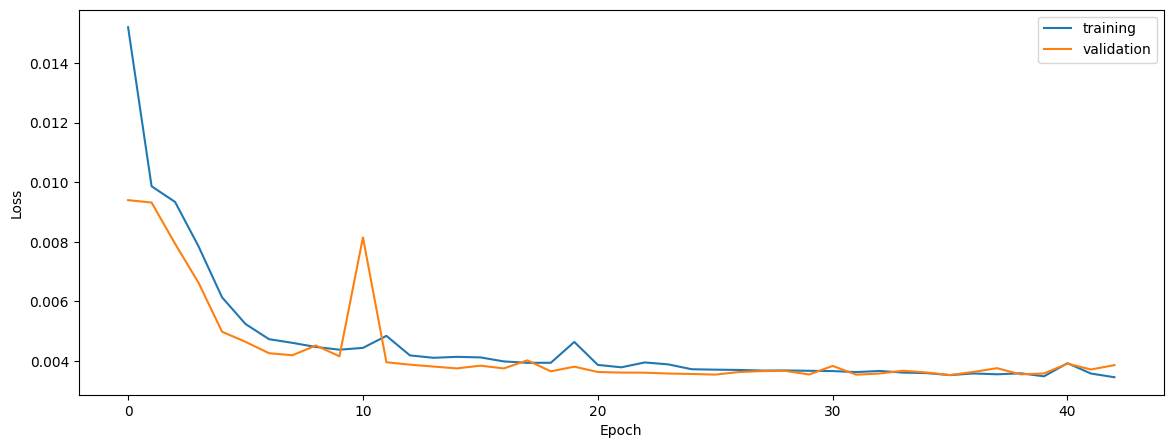

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8049800861161758
0.7910074183215765
0.7927887209949871


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.8065582606690348
0.8109767415714254
0.7928791925218276


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.8107963855778236
0.8085758667735697
0.7973052201434259


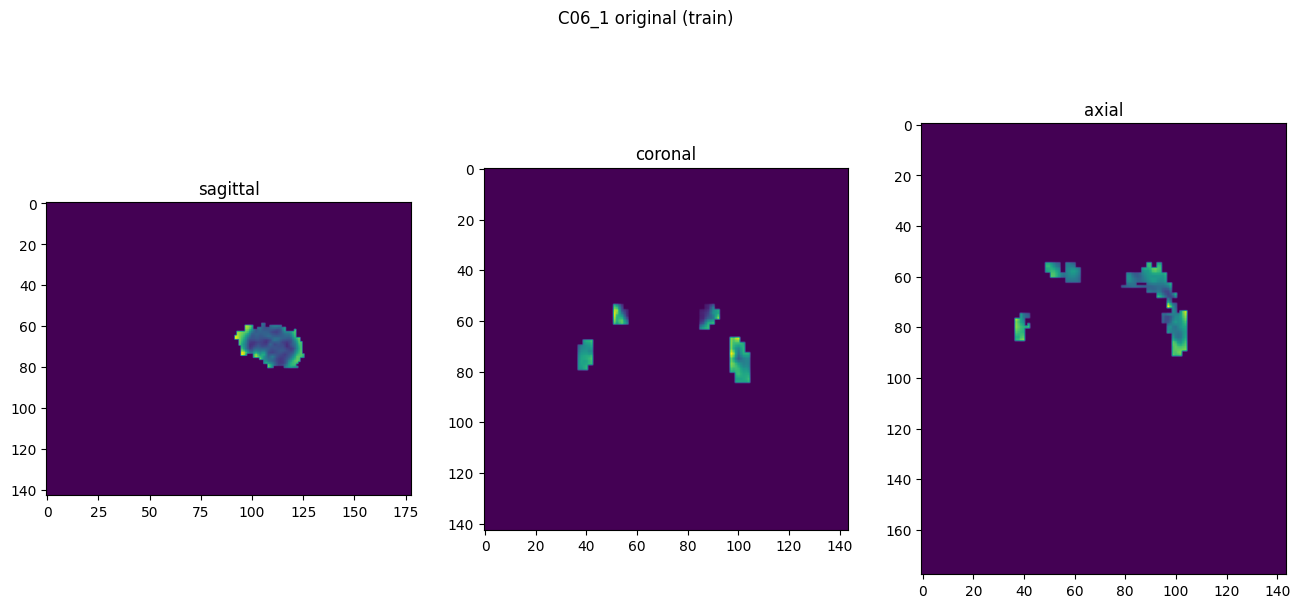

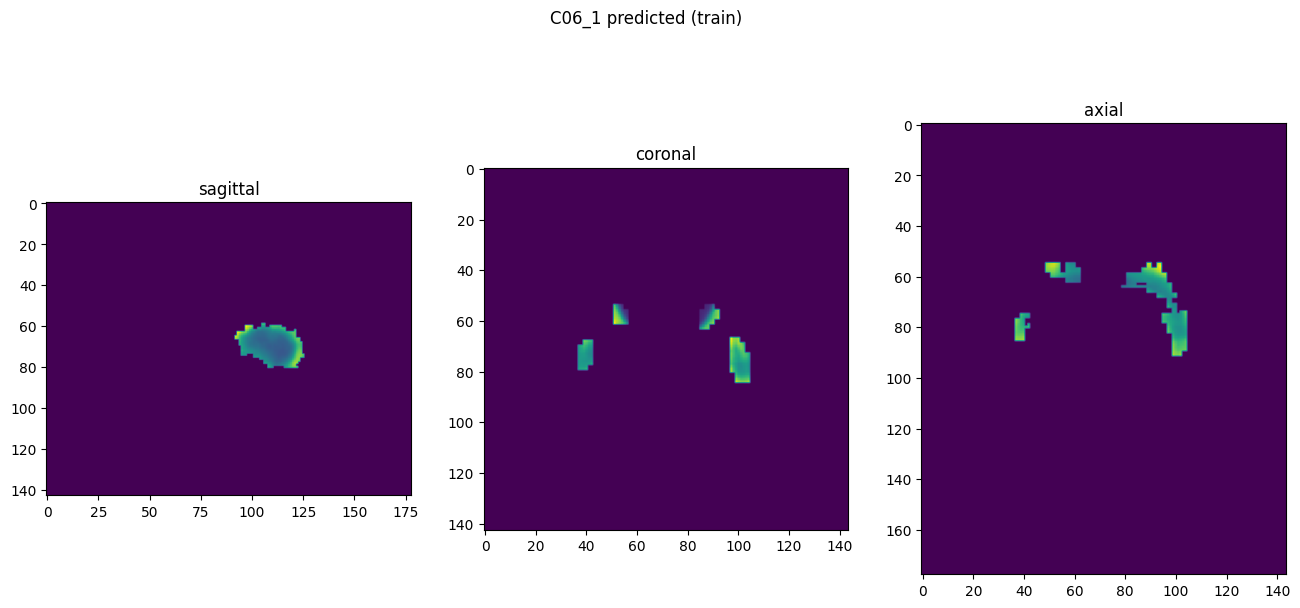

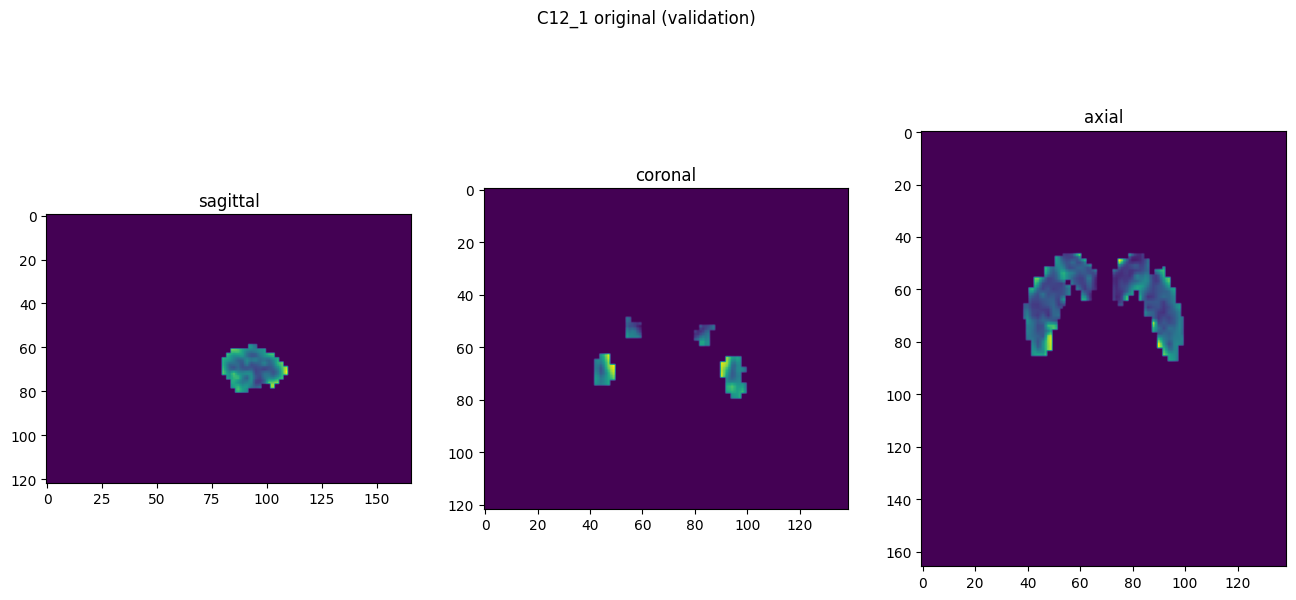

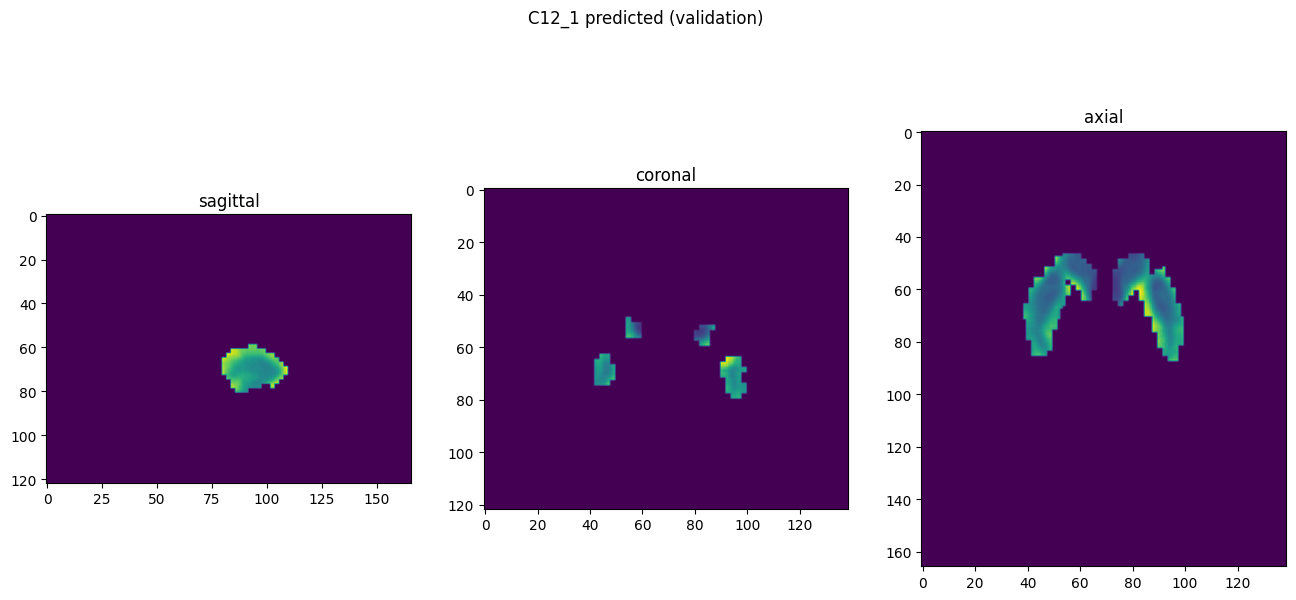

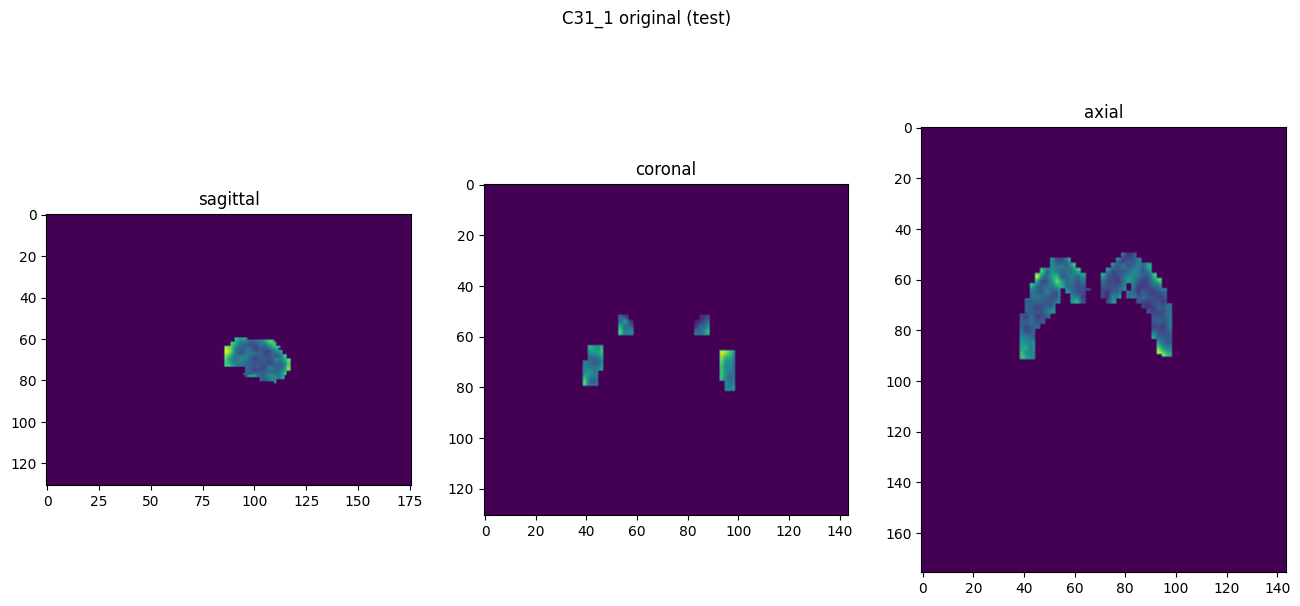

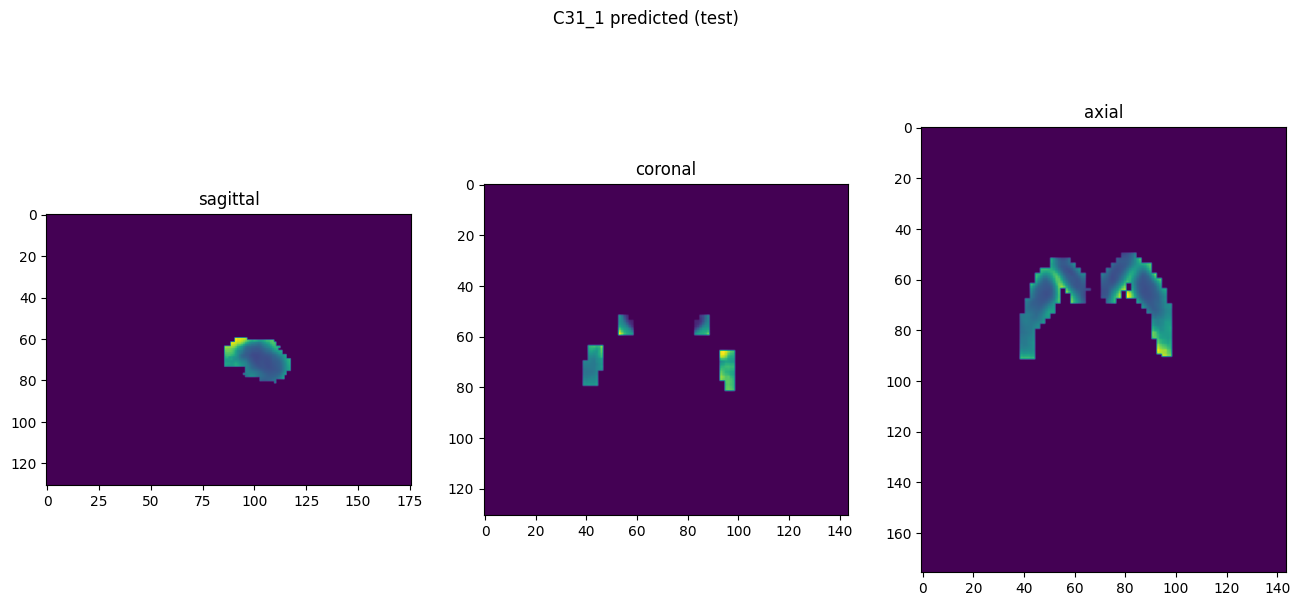

In [10]:
showResults(model, gen, threshold=None, background=False)